### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install library for BERT

In [2]:
!pip install transformers

     |████████████████████████████████| 1.4MB 6.6MB/s 
     |████████████████████████████████| 890kB 37.0MB/s 
     |████████████████████████████████| 2.9MB 33.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8f65a56f4e259ed4974da0a7a27671d08752ac2bfebb67e95694fddebe2b9766
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Import Libraries

In [61]:
import pandas as pd 
import numpy as np
import os

from termcolor import colored

from typing import Tuple, List
from functools import partial

#misc
import gc
import time
import warnings

#stats
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
from matplotlib_venn import venn2
from matplotlib_venn import venn3

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, BertPreTrainedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
tokenizer=TweetTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haju1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Explanatory data analysis


In this Challenge, we want to detect multiple types of toxicity in Wikipedia's pages comment sections. First, let's take a look at the data that is given to us.

In [71]:
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [72]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


We have an id column, the comment text and 6 types of toxicity. It seems that not all comments are labeled toxic. Let's see how many of them are 'clean'. 

In [4]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


The majority is clean it seems.
Let's now see the proportion of each toxicity label in the database among the toxic comments.

In [5]:
Features = ['toxic',
            'severe_toxic',
            'obscene',
            'threat',
            'insult',
            'identity_hate']

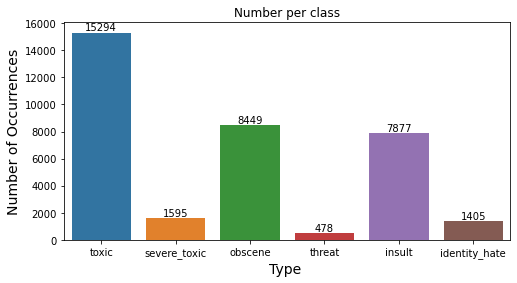

In [11]:
x=train[Features].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values)
plt.title("Number per class")
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Type ', fontsize=14)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The 'toxic' label is predominent, followed by 'obscene' and 'insult'. 
Can there be more than 1 label per comment? 

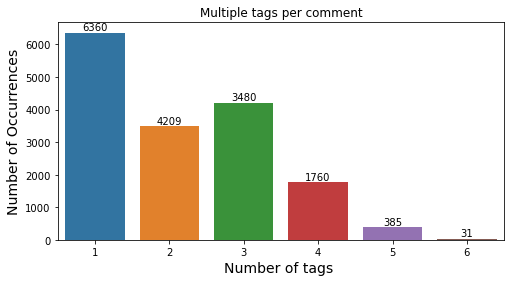

In [12]:
x=rowsums.value_counts()[1:]

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple tags per comment")
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xlabel('Number of tags ', fontsize=14)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The majority of comment have only one label, but it seems that quite a lot have 2 or more labels. Let's add this characteristic to the dataset to see if we can use this information and let's take a look at a comment with 1 label and a comment with 6 labels. 

In [73]:
train['1label'] = rowsums == 1
train['2labels'] = rowsums == 2
train['3labels'] = rowsums == 3
train['4labels'] = rowsums == 4
train['5labels'] = rowsums == 5
train['6labels'] = rowsums == 6

In [64]:
onetag = train[rowsums==1]
sixtags = train[rowsums==6]

In [65]:
print(colored('Toxic','red',attrs=['bold']))
print(onetag['comment_text'].values[0])
print()
print()
print(colored('All','red',attrs=['bold']))
print(sixtags['comment_text'].values[0])

Toxic
Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


All
WOULDN'T BE THE FIRST TIME BITCH. FUCK YOU I'LL FIND OUT WHERE YOU LIVE, SODOMIZE YOUR WIFE AND THEN BURN YOUR HOUSE DOWN. FUCK YOU YOU FUCKING QUEER.


Let's look a little closer at the repartion of those labels. There are a few ways we can do this. 
Venn diagrams are quite handy in this case. 

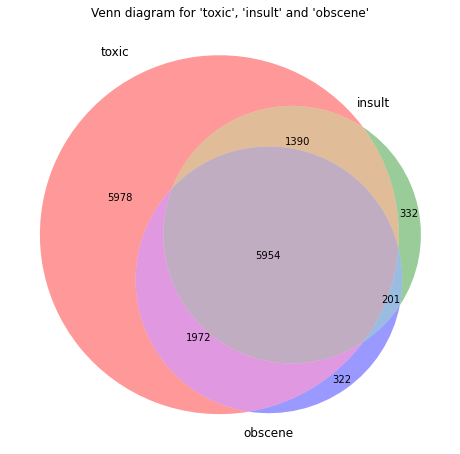

In [13]:
t = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 0)].shape[0]
i = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
o = train[(train['toxic'] == 0) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]

t_i = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 0)].shape[0]
t_o = train[(train['toxic'] == 1) & (train['insult'] == 0) & (train['obscene'] == 1)].shape[0]
i_o = train[(train['toxic'] == 0) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]

t_i_o = train[(train['toxic'] == 1) & (train['insult'] == 1) & (train['obscene'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

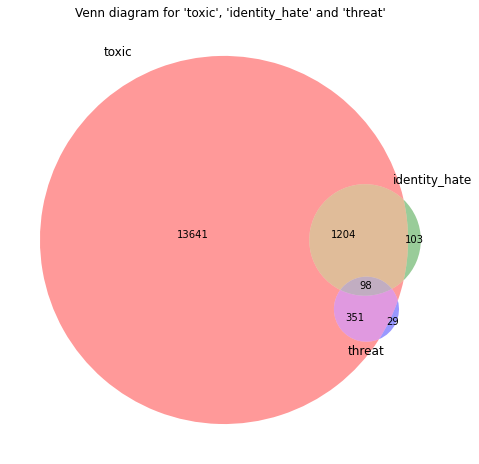

In [14]:
t = train[(train['toxic'] == 1) & (train['identity_hate'] == 0) & (train['threat'] == 0)].shape[0]
i = train[(train['toxic'] == 0) & (train['identity_hate'] == 1) & (train['threat'] == 0)].shape[0]
o = train[(train['toxic'] == 0) & (train['identity_hate'] == 0) & (train['threat'] == 1)].shape[0]

t_i = train[(train['toxic'] == 1) & (train['identity_hate'] == 1) & (train['threat'] == 0)].shape[0]
t_o = train[(train['toxic'] == 1) & (train['identity_hate'] == 0) & (train['threat'] == 1)].shape[0]
i_o = train[(train['toxic'] == 0) & (train['identity_hate'] == 1) & (train['threat'] == 1)].shape[0]

t_i_o = train[(train['toxic'] == 1) & (train['identity_hate'] == 1) & (train['threat'] == 1)].shape[0]


plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'identity_hate' and 'threat'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'identity_hate', 'threat'))
plt.show()

We can also generate crosstabs.

In [20]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [22]:
target="toxic"
corr_mats=[]
for other_col in train[Features].columns[1:]:
    confusion_matrix = pd.crosstab(train[Features][target], train[Features][other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=train[Features].columns[1:])

out = out.style.apply(highlight_min,axis=0)
out

We can observe that a 'severe_toxic' comment is always toxic, makes sense. 
Moreover, the 'toxic' class seems to encompasses a lot of other classes. 
Let's now see the correlation between the classes. 

In [69]:
def plot_correlations(data, target=None, limit=50, figsize=(12,10), **kwargs):
    '''
    This function  plots the correlation matrix of a dataframe
    If a target feature is provided, it will display only a certain amount of features, the ones correlated the most
    with the target. The number of features displayed is controlled by the parameter limit
    '''
    corr = data.corr()
    if target:
        corr['abs'] = abs(corr[target])
        cor_target = corr.sort_values(by='abs', ascending=False)[target]
        cor_target = cor_target[:limit]
        del corr['abs']
        corr = corr.loc[cor_target.index, cor_target.index]
    plt.figure(figsize=figsize)
    ax = sns.heatmap(corr, cmap='RdBu_r', **kwargs)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    return cor_target

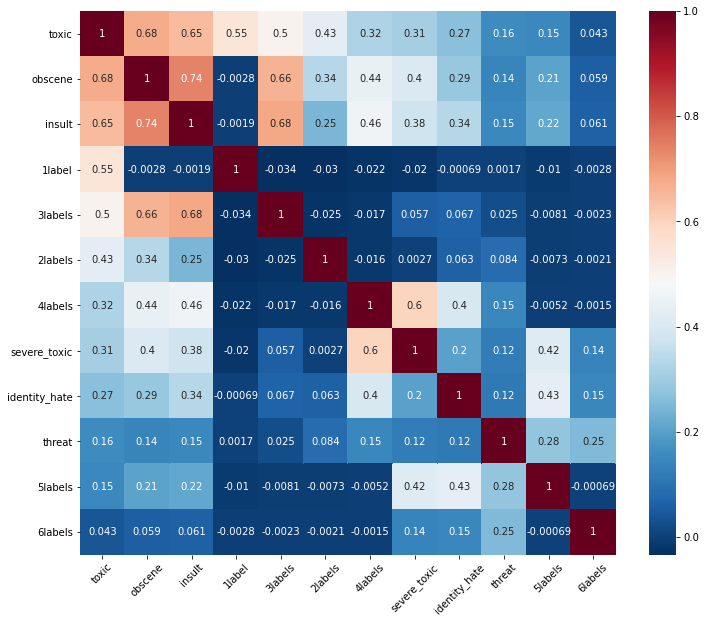

In [74]:
corr = plot_correlations(train[2:], 'toxic', limit=15, annot=True)

Toxic and obscene as well as toxic and insult seem to be corrolated. 
Toxic and Severe_toxic only got a 31% correlation -> clear separation between the two classes. 
Insult and obscene have a 74% correlation. 

Let's now take a look at the most important words in each category. There are a few ways we can do this. Let's use the Term Frequency - Inverse Document Frequency (TF-iDF) metric which computes a weight which represents the importance of a term inside a document. It does this by comparing the frequency of usage inside an individual document as opposed to the entire data set (a collection of documents).<br/> Mathematically : <br/><br/>
TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)<br/><br/>
IDF(t) = log_e(Total number of documents / Number of documents with term t in it).<br/><br/>
Value = TF * IDF<br/>

In [93]:
train_tfid=pd.read_csv("train.csv")

In [102]:
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(train_tfid['comment_text'])

train_unigrams =  tfv.transform(train_tfid['comment_text'].iloc[:train_tfid.shape[0]])

In [95]:
#https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [103]:
train_tags=train_tfid.iloc[:,2:8]
features = np.array(tfv.get_feature_names())
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)

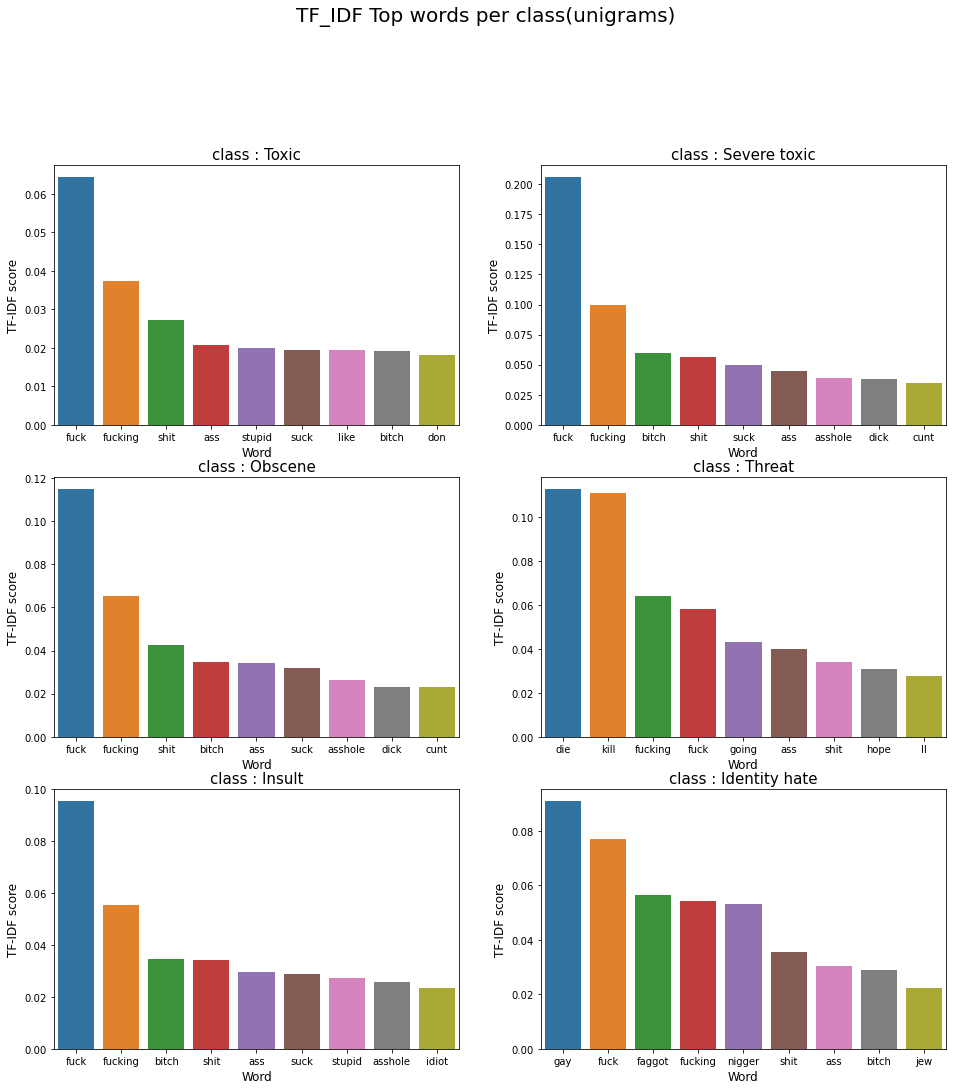

In [110]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

We can see that we observe very similar words accross all categories except 'Identity hate' which has words related to sexual orientation, ethnicity or religion. 

In [115]:
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(train_tfid['comment_text'])

train_bigrams =  tfv.transform(train_tfid['comment_text'].iloc[:train_tfid.shape[0]])

In [116]:
features = np.array(tfv.get_feature_names())
#get top n for bigrams
tfidf_top_n_per_lass=top_feats_by_class(train_bigrams,features)

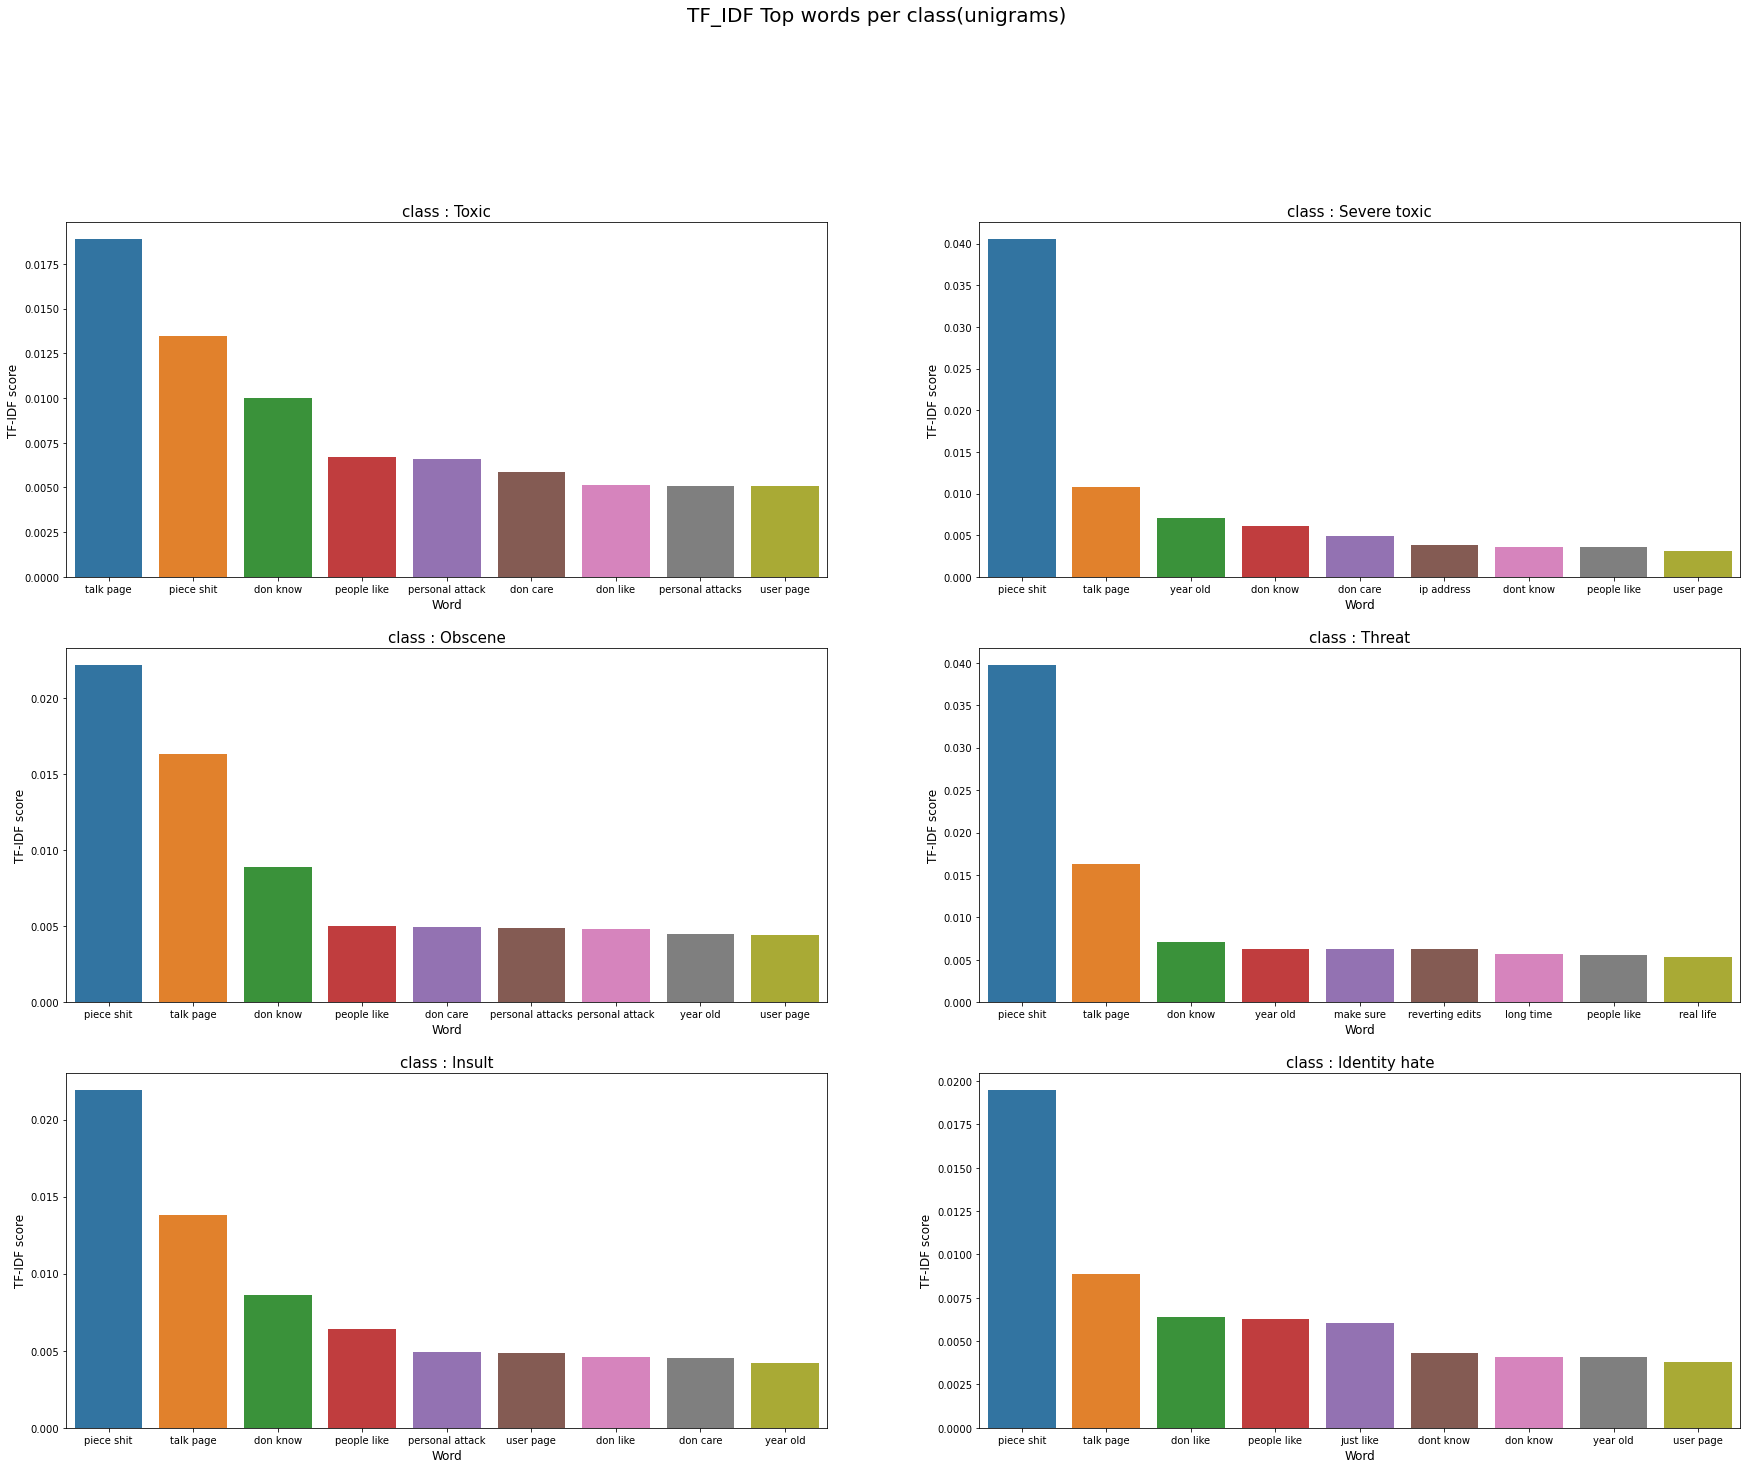

In [119]:
plt.figure(figsize=(30,30))
plt.suptitle("TF_IDF Top words per class(unigrams)",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9])
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9])
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9])
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9])
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9])
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9])
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


plt.show()

For bigrams, we observe that 'user page' and 'talk page' seems to take an important place although they don't seem to be related to the toxicity lexical field. We can also observe that 'don't know' and 'don know' appear both. This probably means that we could probably clean the dataset first to get better results. 

We can also visualize the importance of each word by its occurence in a wordcloud graphic.

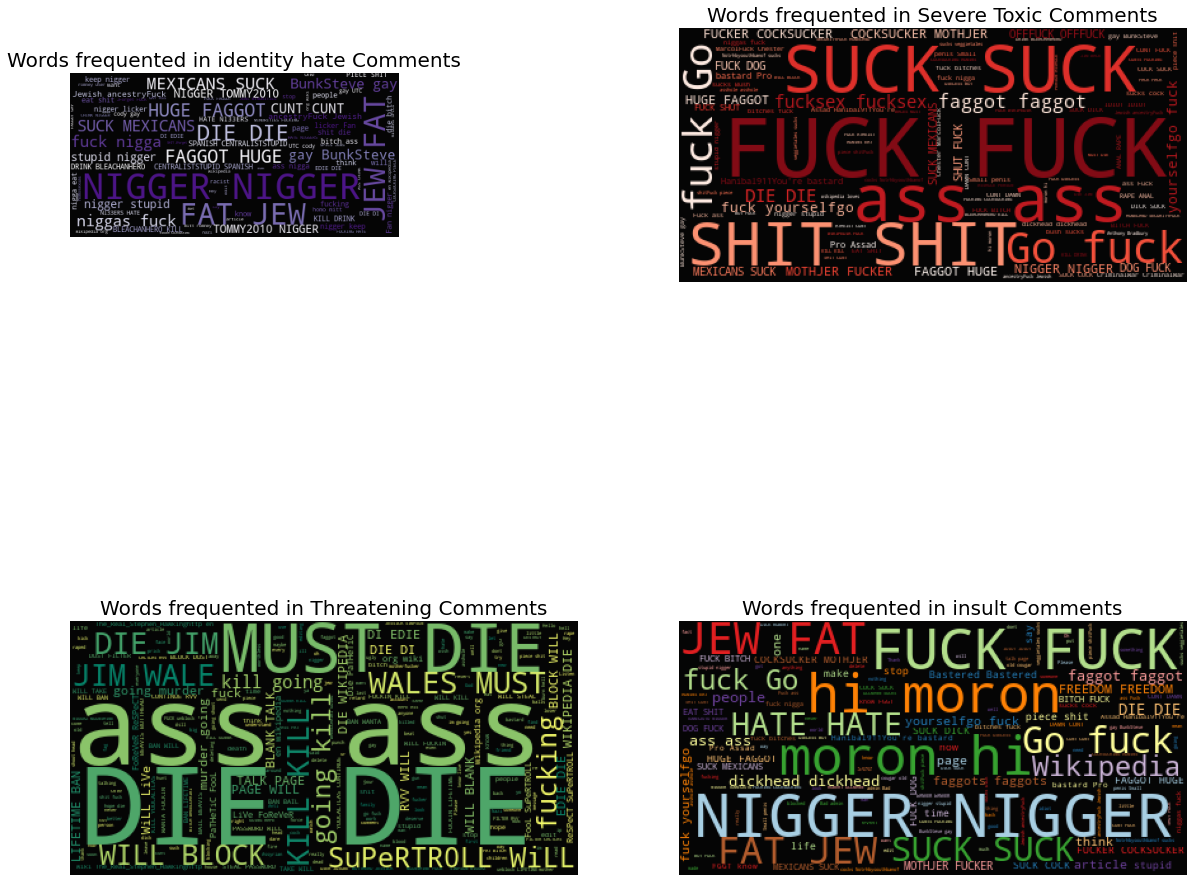

In [27]:
stopword=set(STOPWORDS)

subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#insult
plt.subplot(231)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in identity hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Purples' , random_state=244), alpha=0.98)

plt.show()

Let's now see if the comment structure can give us some information about the classes. We'll look at the length of the comment and some features like the number of uppercase words or exclamation marks which could have an impact on the classification. 

In [75]:
train['total_length'] = train['comment_text'].str.len()
train['new_line'] = train['comment_text'].str.count('\n'* 1)
train['new_small_space'] = train['comment_text'].str.count('\n'* 2)
train['new_medium_space'] = train['comment_text'].str.count('\n'* 3)
train['new_big_space'] = train['comment_text'].str.count('\n'* 4)
train['new_big_space'] = train['comment_text'].str.count('\n'* 4)
train['uppercase_words'] = train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
train['question_mark'] = train['comment_text'].str.count('\?')
train['exclamation_mark'] = train['comment_text'].str.count('!')

In [76]:
FEATURES = ['toxic',
            'severe_toxic',
            'obscene',
            'threat',
            'insult',
            'identity_hate',
            'total_length', 
            'new_line', 
            'new_small_space',  
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']

In [77]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,1label,2labels,...,5labels,6labels,total_length,new_line,new_small_space,new_medium_space,new_big_space,uppercase_words,question_mark,exclamation_mark
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,False,False,...,False,False,264,1,0,0,0,17,1,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,False,False,...,False,False,112,0,0,0,0,8,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,False,False,...,False,False,233,0,0,0,0,4,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,False,False,...,False,False,622,4,1,0,0,11,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,False,False,...,False,False,67,0,0,0,0,2,1,0


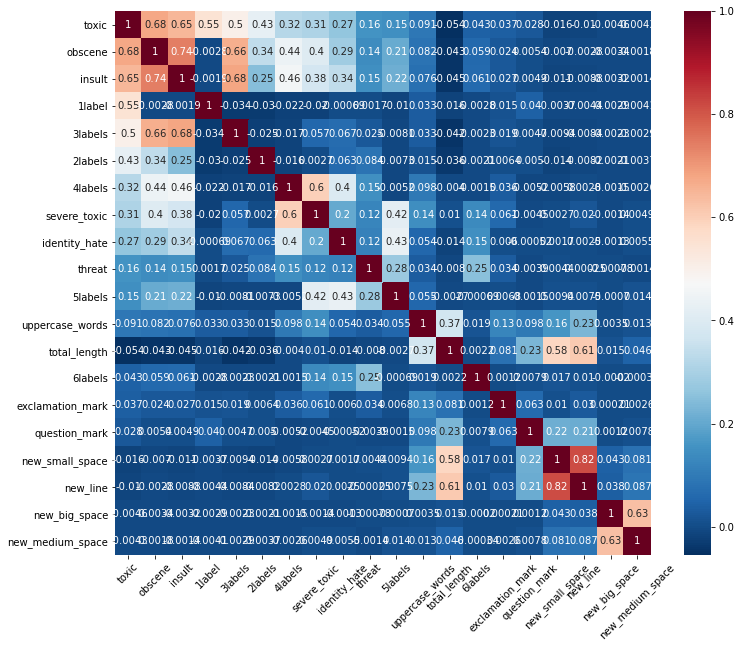

In [80]:
corr = plot_correlations(train[2:], 'toxic', limit=20, annot=True)

Except from the uppercase word feature whch is corrolated at 14% with severe toxic, there doesn't seem to be any other notable correlation. the number of labels per comment doesn't seem to be correlated with any of the intrisic characteristics of the comment. 

# BERT

We will use a Bert model pretrained on cased English text (we take a cased pretrained bert model to take into account the uppercase words that could have an impact on the sentiment of a comment). The pretrained network is multi-headed (12 heads) composed of 12 layers, 768 hidden -->  109M parameters.
The model is then fine tuned with our dataset on Google Collab GPU for two epochs. 

In [23]:
#importing the dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

Train validation split : 80%/20%.

In [17]:
bert_model_name = 'bert-base-cased'
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
assert tokenizer.pad_token_id == 0, 
train_df, val_df = train_test_split(train, test_size=0.2)

In [18]:
class ToxicDataset(Dataset):
    
    def __init__(self, tokenizer: BertTokenizer, dataframe: pd.DataFrame):
        self.tokenizer = tokenizer
        self.pad_idx = tokenizer.pad_token_id
        self.lazy = lazy
        self.df = dataframe      
        
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int) -> Tuple[torch.LongTensor, torch.LongTensor]:
        return self.row_to_tensor(self.tokenizer, self.df.iloc[index])
            

def collate_fn(batch: List[Tuple[torch.LongTensor, torch.LongTensor]], device: torch.device) \
        -> Tuple[torch.LongTensor, torch.LongTensor]:
    x, y = list(zip(*batch))
    x = pad_sequence(x, batch_first=True, padding_value=0)
    y = torch.stack(y)
    return x.to(device), y.to(device)

train_dataset = ToxicDataset(tokenizer, train_df)
val_dataset = ToxicDataset(tokenizer, val_df)
collate_fn = partial(collate_fn, device=device)
BATCH_SIZE = 32
train_sampler = RandomSampler(train_dataset)
val_sampler = RandomSampler(val_dataset)
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, collate_fn=collate_fn)
val_iterator = DataLoader(dev_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, collate_fn=collate_fn)

Downloading pretrained weights and initializing Bert.

In [9]:
class BertClassifier(nn.Module):
    
    def __init__(self, bert: BertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = nn.Linear(bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,labels=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1] 
        cls_output = self.classifier(cls_output) 
        cls_output = torch.sigmoid(cls_output)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(cls_output, labels)
        return loss, cls_output

model = BertClassifier(BertModel.from_pretrained(bert_model_name), 6).to(device)

Train and Eval function.

In [ ]:
def train(model, iterator, optimizer, scheduler):
    model.train()
    total_loss = 0
    for x, y in tqdm(iterator):
        optimizer.zero_grad()
        mask = (x != 0).float()
        loss, outputs = model(x, attention_mask=mask, labels=y)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print(f"Train loss {total_loss / len(iterator)}")

def evaluate(model, iterator):
    model.eval()
    pred = []
    true = []
    with torch.no_grad():
        total_loss = 0
        for x, y in tqdm(iterator):
            mask = (x != 0).float()
            loss, outputs = model(x, attention_mask=mask, labels=y)
            total_loss += loss
            true += y.cpu().numpy().tolist()
            pred += outputs.cpu().numpy().tolist()
    true = np.array(true)
    pred = np.array(pred)
    for i, name in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        print(f"{name} roc_auc {roc_auc_score(true[:, i], pred[:, i])}")
    print(f"Evaluate loss {total_loss / len(iterator)}")

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
{'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
EPOCH_NUM = 2
# triangular learning rate, linearly grows untill half of first epoch, then linearly decays 
warmup_steps = 10 ** 3
total_steps = len(train_iterator) * EPOCH_NUM - warmup_steps
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

# Train

We can decide to save the the model between each epoch but only two epochs here so not necessary. 

In [ ]:
for i in range(EPOCH_NUM):
    print('=' * 50, f"EPOCH {i}", '=' * 50)
    train(model, train_iterator, optimizer, scheduler)
    evaluate(model, dev_iterator)


  0%|          | 0/3990 [00:00<?, ?it/s]

================================================== EPOCH 0 ==================================================



  7%|▋         | 265/3990 [03:14<45:13,  1.37it/s]

100%|██████████| 3990/3990 [48:58<00:00,  1.36it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

Train loss 0.04984176605070397



100%|██████████| 998/998 [04:51<00:00,  3.43it/s]

  0%|          | 0/3990 [00:00<?, ?it/s]

toxic roc_auc 0.986502734826519
severe_toxic roc_auc 0.991910375553072
obscene roc_auc 0.9920143782899299
threat roc_auc 0.9873303990003535
insult roc_auc 0.9883288003761931
identity_hate roc_auc 0.9793898308721426
Evaluate loss 0.0408351793885231
================================================== EPOCH 1 ==================================================



100%|██████████| 3990/3990 [48:58<00:00,  1.36it/s]

  0%|          | 0/998 [00:00<?, ?it/s]

Train loss 0.034093817916931



100%|██████████| 998/998 [04:50<00:00,  3.43it/s]


toxic roc_auc 0.9873951100941266
severe_toxic roc_auc 0.9923315012426576
obscene roc_auc 0.9927244950180347
threat roc_auc 0.9923647871932788
insult roc_auc 0.9886033620138192
identity_hate roc_auc 0.9847222746971498
Evaluate loss 0.039970993995666504


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Toxic_Comments/first_model.pt")

# Submission

In [19]:
model.load_state_dict(torch.load("/content/drive/My Drive/Toxic_Comments/first_model.pt"))
model.eval()
test_df = pd.read_csv("/content/drive/My Drive/Toxic_Comments/test.csv")
submission = pd.read_csv("/content/drive/My Drive/Toxic_Comments/sample_submission.csv")
columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for i in tqdm(range(len(test_df) // BATCH_SIZE + 1)):
    batch_df = test_df.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
    assert (batch_df["id"] == submission["id"][i * BATCH_SIZE: (i + 1) * BATCH_SIZE]).all(), f"Id mismatch"
    texts = []
    for text in batch_df["comment_text"].tolist():
        text = tokenizer.encode(text, add_special_tokens=True)
        if len(text) > 120:
            text = text[:119] + [tokenizer.sep_token_id]
        texts.append(torch.LongTensor(text))
    x = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    mask = (x != tokenizer.pad_token_id).float().to(device)
    with torch.no_grad():
        _, outputs = model(x, attention_mask=mask)
    outputs = outputs.cpu().numpy()
    submission.iloc[i * BATCH_SIZE: (i + 1) * BATCH_SIZE][columns] = outputs

  0%|          | 0/4787 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
100%|██████████| 4787/4787 [21:45<00:00,  3.67it/s]


In [22]:
submission.to_csv("/content/drive/My Drive/Toxic_Comments/submission.csv", index=False)

Submission results : mean column-wise ROC AUC = 0.98108 